In [97]:
from keras.applications.resnet import ResNet50,preprocess_input
from keras.preprocessing.image import ImageDataGenerator 
from keras.layers import Dense,Flatten,Dropout
from keras.models import Model
from keras import optimizers
from keras.callbacks import ModelCheckpoint,EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [98]:
height=300
width=300
base_model=ResNet50(weights='imagenet',include_top=False,input_shape=(height,width,3))

In [99]:
train_dir="Dataset/Training"
validation_dir="Dataset/Validation"

batch_size=10

train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,rotation_range=90,horizontal_flip=True,vertical_flip=True)
train_generator=train_datagen.flow_from_directory(train_dir,target_size=(height,width),batch_size=batch_size)

validation_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,rotation_range=90,horizontal_flip=True,vertical_flip=True)
validation_generator=validation_datagen.flow_from_directory(validation_dir,target_size=(height,width),batch_size=batch_size)

Found 35 images belonging to 2 classes.
Found 7 images belonging to 2 classes.


In [100]:
def build_finetune_model(base_model,dropout,fc_layers,num_classes):
    for layer in base_model.layers:
        layer.trainable=False
    x=base_model.output
    x=Flatten()(x)
    for fc in fc_layers:
        x=Dense(fc,activation='relu')(x)
        x=Dropout(dropout)(x)
    predictions=Dense(num_classes,activation='softmax')(x)
    finetune_model=Model(inputs=base_model.input,outputs=predictions) 
    return finetune_model

In [101]:
class_list = ['Real', 'Fake']
FC_Layers = [1024, 1024]
dropout = 0.5
num_epochs = 100
num_train_images = 35
metric = 'val_accuracy'


In [102]:
finetune_model = build_finetune_model(
    base_model, dropout=dropout, fc_layers=FC_Layers, num_classes=len(class_list))


In [103]:
checkpoint = ModelCheckpoint("Final_model.h5", monitor=metric, verbose=1,save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor=metric, min_delta=0,patience=40, verbose=1, mode="auto")
callbacks = [checkpoint, early]
finetune_model.compile(loss="categorical_crossentropy",optimizer=optimizers.Adam(lr=0.000001),metrics=['accuracy'])
finetune_model.fit_generator(generator=train_generator,steps_per_epoch=num_train_images//batch_size,epochs=num_epochs,validation_data=validation_generator,validation_steps=1,callbacks=callbacks)
finetune_model.save("Final_model.h5")


Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 2.0525 - accuracy: 0.5200
Epoch 1: val_accuracy improved from -inf to 0.57143, saving model to Final_model.h5
3/3 [==============================] - 32s 13s/step - loss: 2.0525 - accuracy: 0.5200 - val_loss: 1.2159 - val_accuracy: 0.5714
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 1.7236 - accuracy: 0.4000
Epoch 2: val_accuracy did not improve from 0.57143
3/3 [==============================] - 5s 2s/step - loss: 1.7236 - accuracy: 0.4000 - val_loss: 0.9157 - val_accuracy: 0.5714
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 1.1344 - accuracy: 0.5200
Epoch 3: val_accuracy did not improve from 0.57143
3/3 [==============================] - 5s 2s/step - loss: 1.1344 - accuracy: 0.5200 - val_loss: 1.3819 - val_accuracy: 0.5714
Epoch 4/100
3/3 [==============================] - ETA: 0s - loss: 1.3620 - accuracy: 0.6000
Epoch 4: val_accuracy improved from 0.57143 to 0.71429, saving

1/1 [==============================] - 2s 2s/step
[[0.07736683 0.9226331 ]]
Real


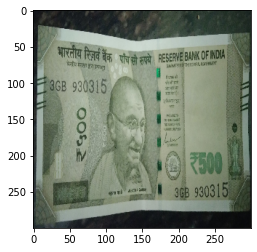

In [107]:
from keras.utils import load_img
from keras.models import load_model

img=load_img("Dataset/Testing/Real.jpg",target_size=(300,300)) 
plt.imshow(img)
img=np.expand_dims(img,axis=0)
reconstructed_model = load_model("Final_model.h5")

output=reconstructed_model.predict(img) 
print(output)
if(output[0][0]>output[0][1]): print("Fake")
else:print("Real")


1/1 [==============================] - 0s 248ms/step


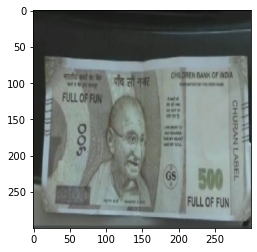

In [108]:
img = load_img("Dataset\Testing\Fake.jpeg", target_size=(300, 300))
plt.imshow(img)
img = np.expand_dims(img, axis=0)
output = reconstructed_model.predict(img)


In [109]:
print(output)

[[0.9075712  0.09242877]]


In [106]:
if(output[0][0] > output[0][1]):
    print("Fake")
else:
    print("Real")


Fake
